# What is a Knowledge Graph?

### We can define a graph as a set of nodes and edges.

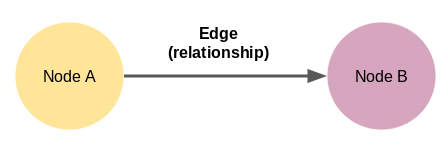

Node A and Node B here are two different entities. These nodes are connected by an edge that represents the relationship between the two nodes. Now, this is the smallest knowledge graph python we can build – it is also known as a triple.

Knowledge Graph’s come in a variety of shapes and sizes. For example, the knowledge graph of Wikidata had 59,910,568 nodes by October 2019.

To build a knowledge graph Python from the text, it is important to make our machine understand natural language. This can be done by using NLP techniques such as sentence segmentation, dependency parsing, parts of speech tagging, and entity recognition.

In [30]:
import spacy
nlp = spacy.load('en_core_web_sm')

doc = nlp("The 22-year-old recently won ATP Challenger tournament.")

for tok in doc:
  print(tok.text, "...", tok.dep_)

The ... det
22 ... nummod
- ... punct
year ... npadvmod
- ... punct
old ... nsubj
recently ... advmod
won ... ROOT
ATP ... compound
Challenger ... compound
tournament ... dobj
. ... punct


In [32]:
#we will use dependency parsing to extract entities.
doc = nlp("Nagal won the first set.")

for tok in doc:
  print(tok.text, "...", tok.dep_)

Nagal ... nsubj
won ... ROOT
the ... det
first ... amod
set ... dobj
. ... punct


To extract the relation, we have to find the ROOT of the sentence (which is also the verb of the sentence). Hence, the relation extracted from this sentence would be “won”.

Finally, the knowledge graph from these two sentences will be like this:

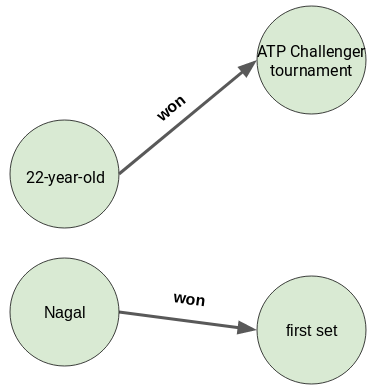

# Build a Knowledge Graph from Text Data

In [ ]:
#Import Libraries
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline


In [34]:
# import wikipedia sentences
candidate_sentences = pd.read_csv("wiki_sentences_v2.csv")
candidate_sentences.shape

(4318, 1)

In [36]:
candidate_sentences.columns

Index(['sentence'], dtype='object')

In [38]:
candidate_sentences['sentence'].sample(5)

2498                                  the first truly successful home-grown feature film was yan ruisheng  released in 1921.
1087                                                   polaroid pif-300 film is essentially rebranded fuji instax mini film.
1634                                                                                              pramod is married to simi.
741     disney continued making animated films, notably; cinderella , peter pan , lady and the tramp , and sleeping beauty .
3637                                                                                  both were initially banned in the u.s.
Name: sentence, dtype: object

In [37]:
candidate_sentences.head()  # Display the first few rows of the DataFrame for verification

sentence
0  confused and frustrated, connie decides to leave on her own.
1             later, a woman’s scream is heard in the distance.
2                      christian is then paralyzed by an elder.
3                                    the temple is set on fire.
4                             outside, the cult wails with him.

Let’s check the subject and object of one of these sentences. Ideally, there should be one subject and one object in the sentence:

In [39]:
doc = nlp("the drawdown process is governed by astm standard d823")

for tok in doc:
  print(tok.text, "...", tok.dep_)

the ... det
drawdown ... amod
process ... nsubjpass
is ... auxpass
governed ... ROOT
by ... agent
astm ... compound
standard ... compound
d823 ... pobj


There is only one subject (‘process’) and only one object (‘standard’)

### To build a knowledge graph, the most important things are the nodes and the edges between them.

In [44]:
#function below to extract the subject and the object (entities) from a sentence
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]


In [45]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 4318/4318 [00:22<00:00, 195.09it/s]


In [71]:
entity_pairs[0:10]

[['connie', 'own'],
 ['later  scream', 'distance'],
 ['christian', 'then  elder'],
 ['temple', 'fire'],
 ['', 'outside cult him'],
 ['it', 'religious  awakening'],
 ['c. mackenzie', 'craig cast'],
 ['later craig di francia', 'action cast'],
 ['sebastian  maniscalco', 'later paul ben cast'],
 ['we', 'just  film']]

In [80]:
def get_relation(sent):
  doc = nlp(sent)
  matcher = Matcher(nlp.vocab)

  pattern = [{'DEP':'ROOT'}, 
         {'DEP':'prep','OP':"?"}, 
         {'DEP':'agent','OP':"?"},  
         {'POS':'ADJ','OP':"?"}]
  
  matcher.add("matching_1", [pattern])  # Pass pattern as a list

  matches = matcher(doc)
  if not matches:
    return ""
  k = len(matches) - 1
  span = doc[matches[k][1]:matches[k][2]]
  return span.text


In [81]:
get_relation("John completed the task")

'completed'

In [82]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]

100%|██████████| 4318/4318 [00:23<00:00, 185.09it/s]


In [83]:
pd.Series(relations).value_counts()[:50]

is               364
was              308
released on       90
are               74
include           73
were              68
released          41
's                39
composed by       34
became            31
have              31
has               30
become            28
released in       27
included          23
had               21
produced          21
been              20
called            19
used              19
considered        18
made              18
scheduled         17
be                17
directed by       16
stars             16
hired             14
produced by       14
written by        13
wrote             13
received          13
introduced in     13
went              13
wanted            12
sold              12
began in          11
set               11
began             11
cast as           11
won               11
gave              10
directed          10
includes          10
gives              9
going              9
produced in        9
opened             9
features     

### Build a Knowledge Graph

In [84]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [87]:
kg_df.head(5)

source            target          edge
0         connie               own       decides
1  later  scream          distance      heard in
2      christian       then  elder  paralyzed by
3         temple              fire        set on
4                 outside cult him    wails with

Next, we will use the networkx library to create a network from this dataframe. The nodes will represent the entities and the edges or connections between the nodes will represent the relations between the nodes.

It is going to be a directed graph. In other words, the relation between any connected node pair is not two-way, it is only from one node to another. For example, “John eats pasta”:

In [88]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

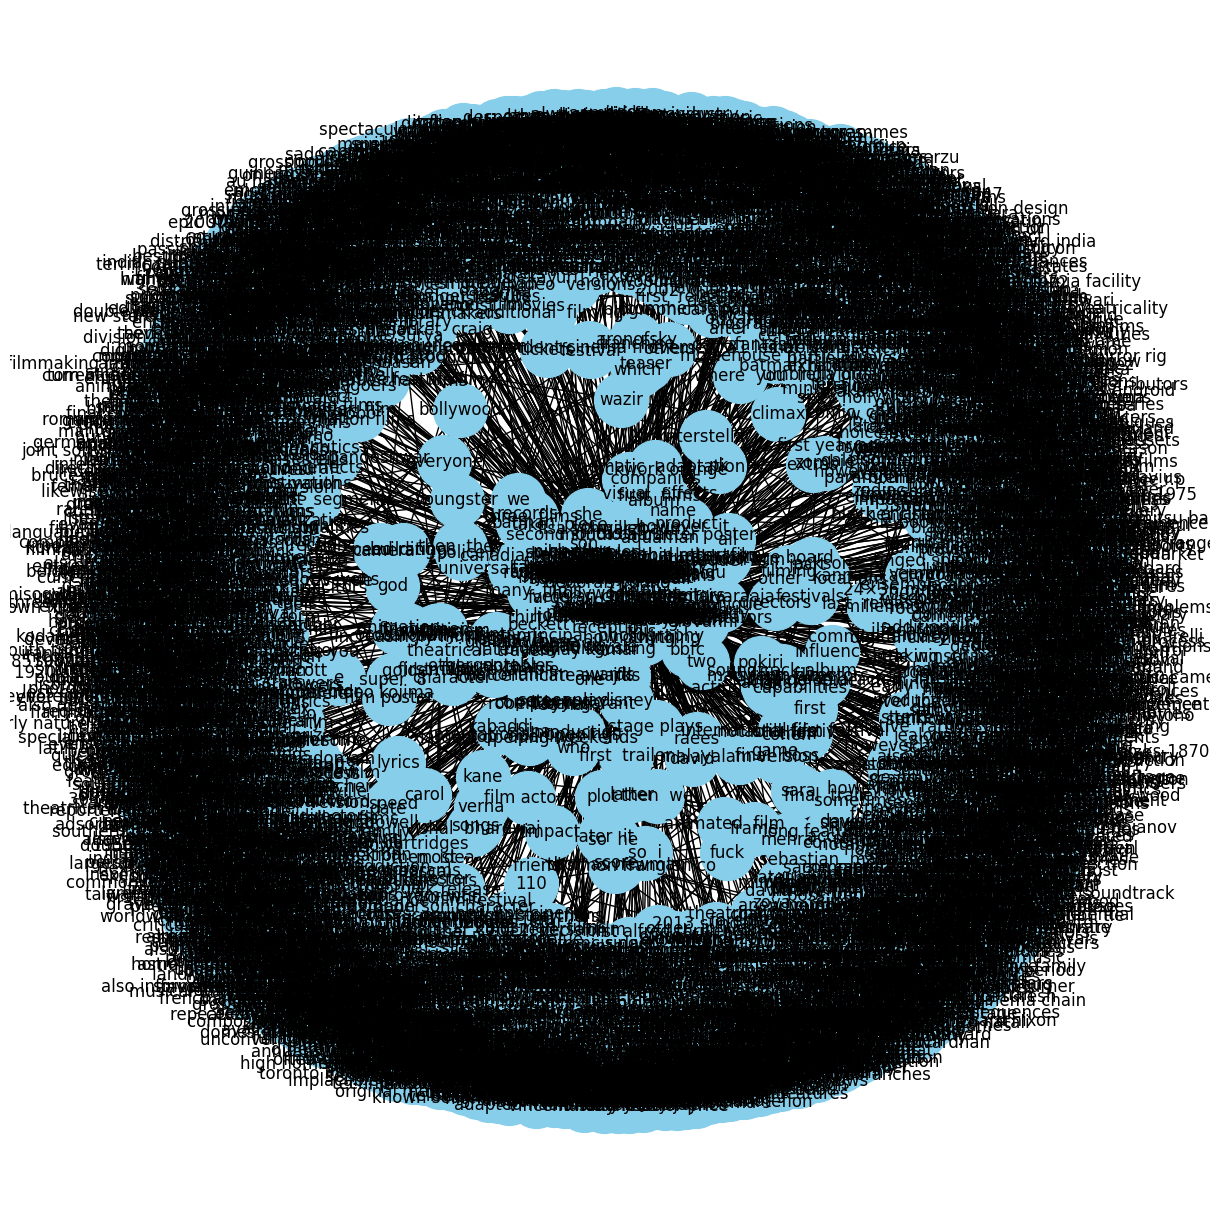

In [89]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue',node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

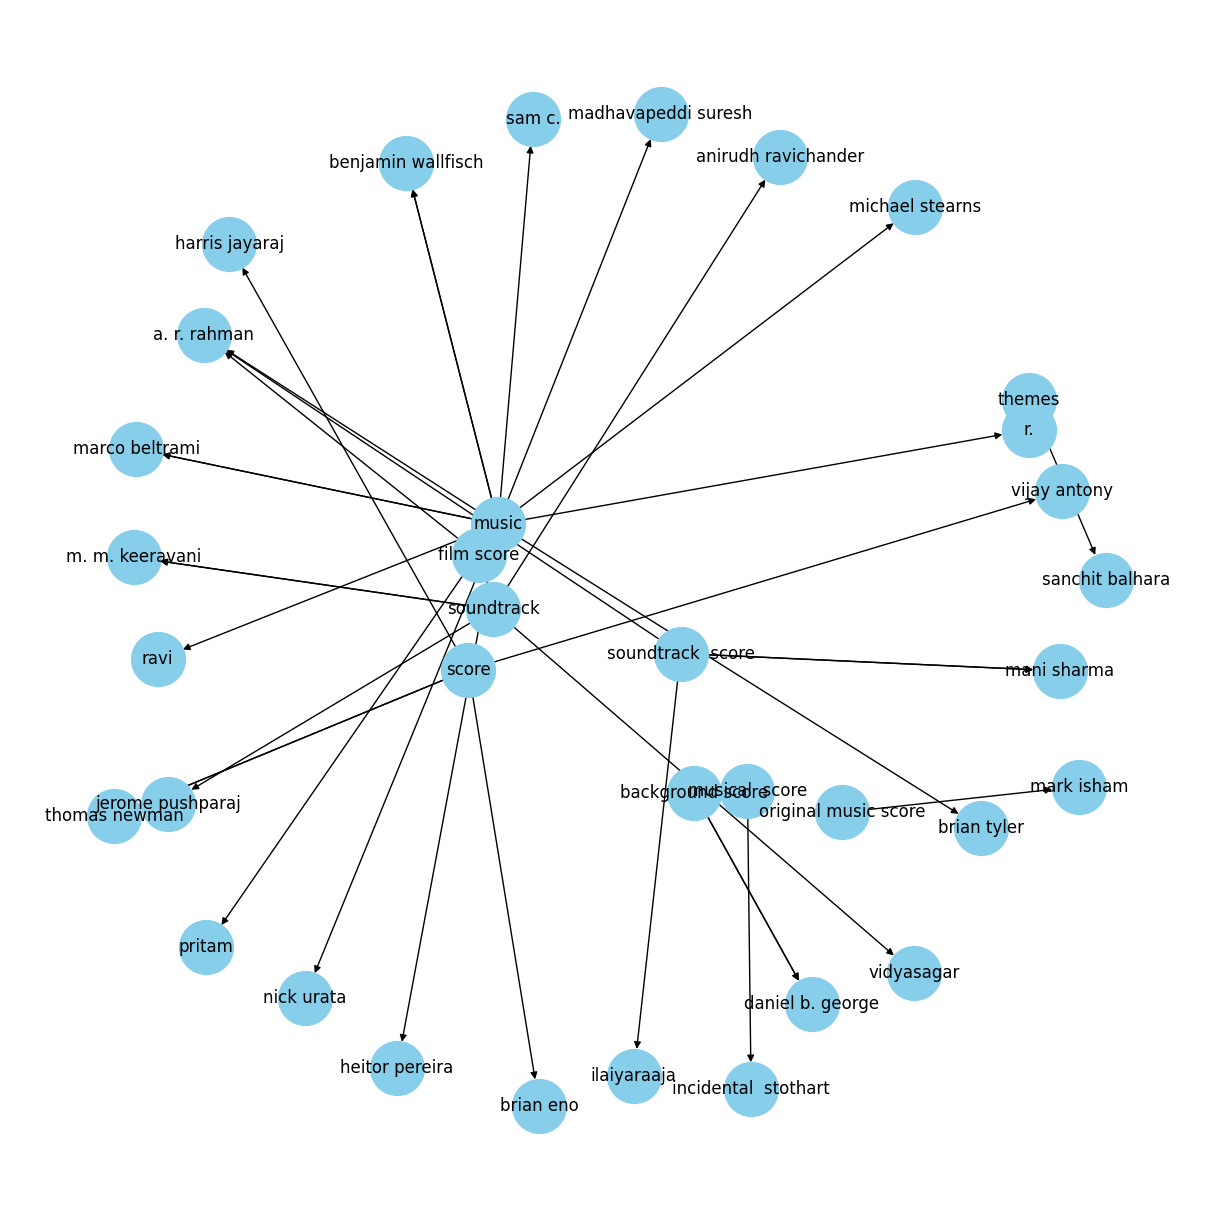

In [90]:
# I will take one relation at a time. Let’s start with the relation “composed by”:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

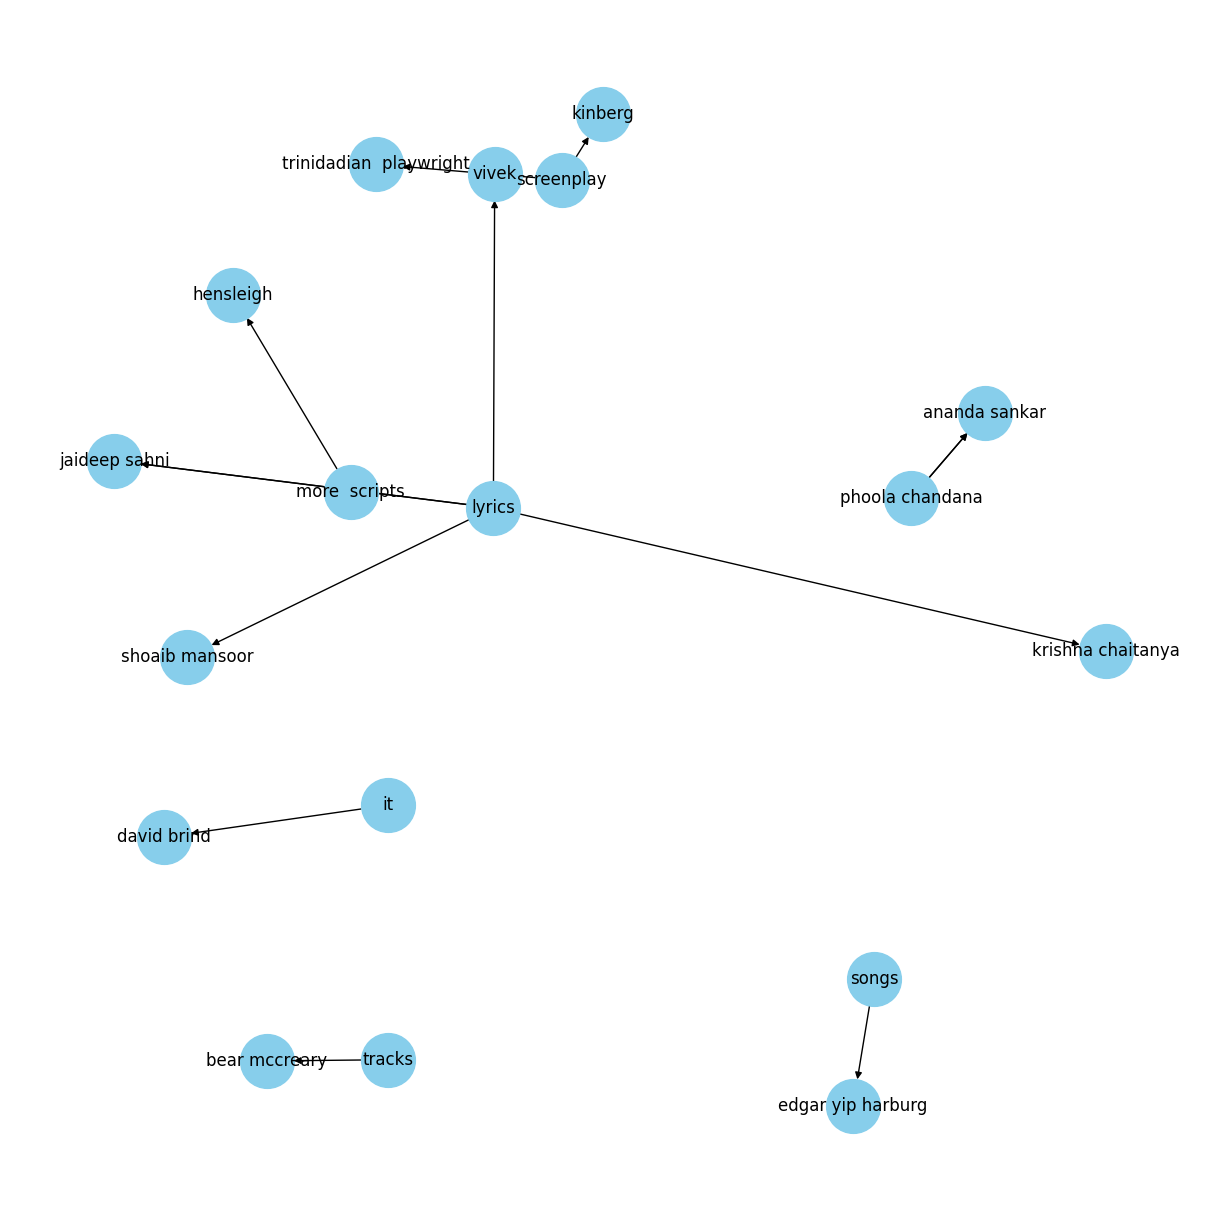

In [91]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="written by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

### Javed Akhtar, Krishna Chaitanya, and Jaideep Sahni are all famous lyricists and this graph beautifully captures this relationship

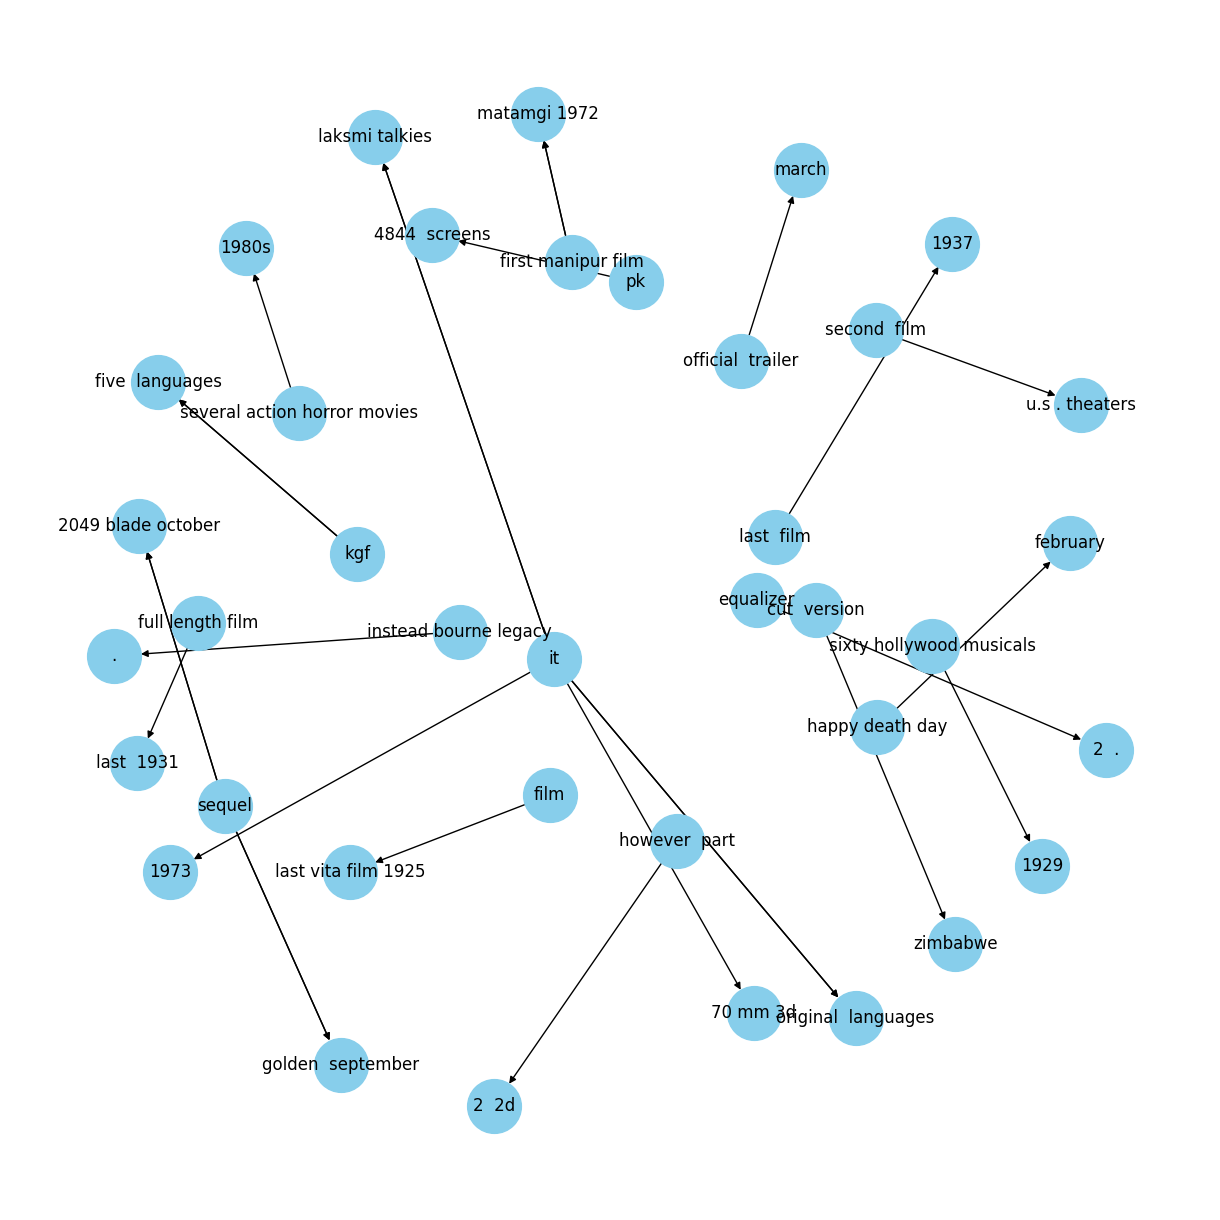

In [92]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released in"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

 For example, look at this relationship – “several action horror movies released in the 1980s” and “pk released on 4844 screens”. These are facts and it shows us that we can mine such facts from just text. That’s quite amazing!

## If you want to extract data from a website and build a Knowledge Graph, refer to the steps below.

Libraries loaded and spaCy model ready.
Processing URL: https://en.wikipedia.org/wiki/Germany
Extracted 56886 characters of text.
Segmented into 307 sentences.
Extracting entities and relations...


Processing sentences:   0%|          | 0/307 [00:00<?, ?it/s]

Extracted 200 entity-relation-entity triplets.

Sample Knowledge Graph Triplet DataFrame:
                 source                target               edge
0       various  tribes     Neolithic  onward           began in
1      Germanic  tribes  classical  antiquity          inhabited
2                region                    AD  documented before
3               Kingdom     Holy Roman Empire             formed
4  German Confederation                  1815          formed in

Generating Knowledge Graph visualization...


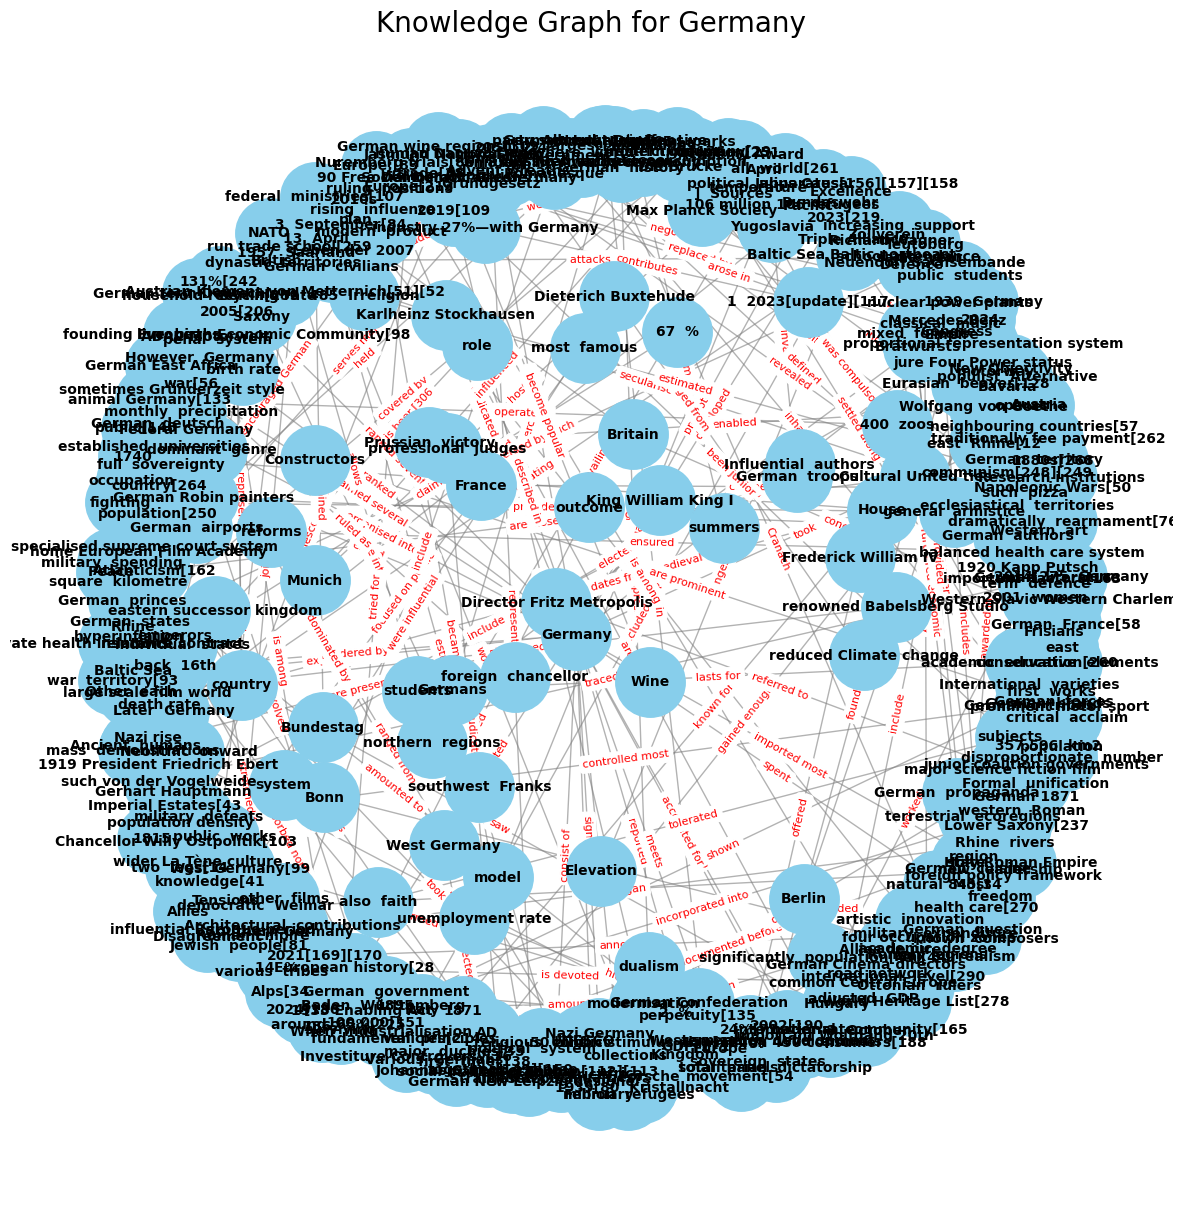

In [27]:
import requests
from bs4 import BeautifulSoup
import spacy
from spacy.matcher import Matcher
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm

# Load the spaCy English model
try:
    nlp = spacy.load('en_core_web_sm')
except OSError:
    print("SpaCy model 'en_core_web_sm' not found. Downloading...")
    # This line is commented out assuming you've run it once successfully
    # !python -m spacy download en_core_web_sm
    nlp = spacy.load('en_core_web_sm')

print("Libraries loaded and spaCy model ready.")

# --- Step 1 & 2: Fetch Web Page Content and Parse HTML/Extract Text ---

def get_page_content(url):
    """Fetches the content of a given URL."""
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an HTTPError for bad responses (4xx or 5xx)
        return response.text
    except requests.exceptions.RequestException as e:
        print(f"Error fetching URL {url}: {e}")
        return None

def extract_text_from_html(html_content):
    """Extracts main text content from HTML using BeautifulSoup."""
    if not html_content:
        return ""

    soup = BeautifulSoup(html_content, 'html.parser')
    
    # Remove script, style, and navigation elements
    for script in soup(["script", "style", "nav", "header", "footer", "aside"]):
        script.extract()

    # Find common content areas for Wikipedia pages
    content_div = soup.find('div', {'id': 'mw-content-text'})
    
    if content_div:
        # Extract text from paragraphs within the main content area
        paragraphs = content_div.find_all('p')
        text = ' '.join([p.get_text() for p in paragraphs if p.get_text().strip()])
    else:
        # Fallback to extracting all visible text if specific content div not found
        text = soup.get_text()
        
    # Clean up whitespace
    text = ' '.join(text.split())
    return text

# --- Step 3: Sentence Segmentation ---

def segment_sentences(text):
    """Segments text into sentences using spaCy."""
    doc = nlp(text)
    return [sent.text for sent in doc.sents if sent.text.strip()]

# --- Step 4: Entity and Relation Extraction (Modified get_entities) ---

# Define common pronouns and stop words to filter out
# This list can be expanded or made more comprehensive
# using spaCy's built-in stop_words set: nlp.Defaults.stop_words
FILTER_WORDS = set(['it', 'he', 'she', 'they', 'we', 'you', 'i', 'this', 'that', 'these', 'those', 'which', 'who', 'what', 'where', 'when', 'why', 'how', 'etc.', 'its'])
FILTER_WORDS.update(nlp.Defaults.stop_words) # Add spaCy's default stop words

def get_entities(sent):
    """
    Extracts subject and object entities from a sentence using spaCy's dependency parsing.
    Handles compound words and modifiers. Filters out common pronouns/stop words.
    """
    ent1 = ""
    ent2 = ""

    prv_tok_dep = ""
    prv_tok_text = ""

    prefix = ""
    modifier = ""

    # Process the sentence with spaCy once
    doc = nlp(sent)

    for tok in doc:
        if tok.dep_ != "punct":
            if tok.dep_ == "compound":
                prefix = tok.text
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " " + tok.text

            if tok.dep_.endswith("mod"):
                modifier = tok.text
                if prv_tok_dep == "compound":
                    modifier = prv_tok_text + " " + tok.text

            if "subj" in tok.dep_:
                candidate_ent1 = (modifier + " " + prefix + " " + tok.text).strip()
                # Filter out pronouns and stop words
                if candidate_ent1.lower() not in FILTER_WORDS and len(candidate_ent1.split()) > 0: # Ensure not empty string after strip
                    ent1 = candidate_ent1
                prefix = ""
                modifier = ""
                prv_tok_dep = ""
                prv_tok_text = ""

            if "obj" in tok.dep_:
                candidate_ent2 = (modifier + " " + prefix + " " + tok.text).strip()
                # Filter out pronouns and stop words
                if candidate_ent2.lower() not in FILTER_WORDS and len(candidate_ent2.split()) > 0:
                    ent2 = candidate_ent2
                prefix = ""
                modifier = ""

            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text

    return [ent1, ent2] # Return cleaned entities


def get_relation(sent):
    """
    Extracts the relation (predicate) from a sentence based on the ROOT verb
    and associated prepositions/agents.
    """
    doc = nlp(sent)
    matcher = Matcher(nlp.vocab)

    # Define the pattern for relation extraction
    # ROOT verb, optionally followed by a preposition, an agent, or an adjective
    pattern = [{'DEP':'ROOT'},
               {'DEP':'prep','OP':"?"},
               {'DEP':'agent','OP':"?"},
               {'POS':'ADJ','OP':"?"}]

    matcher.add("RelationPattern", [pattern])
    matches = matcher(doc)

    if not matches:
        return ""

    # Get the last (and usually most relevant) match
    k = len(matches) - 1
    span = doc[matches[k][1]:matches[k][2]]
    
    # Optional: Filter relation if it's a common stop word or too short
    relation_text = span.text.strip()
    if relation_text.lower() in FILTER_WORDS or len(relation_text) < 2:
        return ""

    return relation_text

# --- Step 5: Build and Visualize Knowledge Graph ---

def build_and_visualize_kg(kg_df, title="Knowledge Graph", num_nodes_to_show=200):
    """
    Builds and visualizes a knowledge graph from a DataFrame of entities and relations.
    Limits the number of nodes for better visualization.
    """
    if kg_df.empty:
        print("No data to build knowledge graph.")
        return

    # Filter out empty strings from source/target/edge
    kg_df = kg_df[kg_df['source'].astype(bool) & kg_df['target'].astype(bool) & kg_df['edge'].astype(bool)]

    if kg_df.empty:
        print("No valid triplets after cleaning. Cannot build knowledge graph.")
        return

    # Take a subset of the DataFrame for better visualization if it's too large
    # Or you could filter by most frequent relations, etc.
    if len(kg_df) > num_nodes_to_show * 2: # Heuristic: if we have significantly more edges than nodes we want to show
        print(f"Graph too large ({len(kg_df)} edges). Showing a sample of {num_nodes_to_show} nodes based on frequency.")
        # Get top entities
        all_entities = pd.concat([kg_df['source'], kg_df['target']]).value_counts()
        top_entities = all_entities.head(num_nodes_to_show).index.tolist()
        
        # Filter DataFrame to include only edges involving top entities
        kg_df_filtered = kg_df[kg_df['source'].isin(top_entities) | kg_df['target'].isin(top_entities)]
        
        if kg_df_filtered.empty and not kg_df.empty: # Fallback if filtering makes it empty, just take a head sample
            kg_df_filtered = kg_df.head(num_nodes_to_show)
        elif kg_df_filtered.empty: # If original was also empty, nothing to do
            print("No valid triplets to visualize after entity filtering.")
            return

        kg_df_to_plot = kg_df_filtered
    else:
        kg_df_to_plot = kg_df

    # Normalize entity names (e.g., remove trailing punctuation, leading/trailing spaces)
    kg_df_to_plot['source'] = kg_df_to_plot['source'].apply(lambda x: x.strip().replace('[d','').replace('.','').strip())
    kg_df_to_plot['target'] = kg_df_to_plot['target'].apply(lambda x: x.strip().replace('.','').strip())

    G = nx.from_pandas_edgelist(kg_df_to_plot, "source", "target",
                                edge_attr=True, create_using=nx.MultiDiGraph())

    plt.figure(figsize=(15, 15))
    pos = nx.spring_layout(G, k=0.7, iterations=50) # Increased iterations for better layout
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=2500)
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, arrowsize=20, alpha=0.6)
    
    # Draw labels
    # Adjust font size for better readability on potentially crowded graphs
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    
    # Draw edge labels (relations)
    edge_labels = nx.get_edge_attributes(G, 'edge')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=8)
    
    plt.title(title, size=20)
    plt.axis('off') # Hide axes
    plt.show()

# --- Main Execution Flow ---

if __name__ == "__main__":
    url = "https://en.wikipedia.org/wiki/Germany"
    print(f"Processing URL: {url}")

    # 1. Fetch content
    html_content = get_page_content(url)

    if html_content:
        # 2. Extract text
        extracted_text = extract_text_from_html(html_content)
        print(f"Extracted {len(extracted_text)} characters of text.")

        # 3. Sentence Segmentation
        sentences = segment_sentences(extracted_text)
        print(f"Segmented into {len(sentences)} sentences.")

        # Limit the number of sentences to process for demonstration and performance
        max_sentences_to_process = 500 # Adjust as needed, try a smaller number first (e.g., 100)
        if len(sentences) > max_sentences_to_process:
            print(f"Limiting processing to the first {max_sentences_to_process} sentences for performance.")
            sentences = sentences[:max_sentences_to_process]


        # 4. Entity and Relation Extraction
        entity_pairs = []
        relations = []

        print("Extracting entities and relations...")
        for sent in tqdm(sentences, desc="Processing sentences"):
            entities = get_entities(sent)
            relation = get_relation(sent)

            # Only add if both entities and a relation are found AND they are not empty/filtered
            # The get_entities and get_relation now handle filtering internally,
            # but this check ensures robustness against any edge cases.
            if entities[0] and entities[1] and relation:
                entity_pairs.append(entities)
                relations.append(relation)

        if not entity_pairs:
            print("No entity-relation-entity triplets found after filtering. Cannot build knowledge graph.")
        else:
            print(f"Extracted {len(entity_pairs)} entity-relation-entity triplets.")

            # Create DataFrame
            source = [pair[0] for pair in entity_pairs]
            target = [pair[1] for pair in entity_pairs]
            kg_df = pd.DataFrame({'source': source, 'target': target, 'edge': relations})

            print("\nSample Knowledge Graph Triplet DataFrame:")
            print(kg_df.head())

            # 5. Build and Visualize Knowledge Graph
            print("\nGenerating Knowledge Graph visualization...")
            build_and_visualize_kg(kg_df, title=f"Knowledge Graph for {url.split('/')[-1].replace('_', ' ')}") # Adjust num_nodes_to_show

    else:
        print("Failed to retrieve content from the URL.")

Graph too large (200 edges). Showing a sample of 10 nodes based on frequency.


C:\Users\hsrak\AppData\Local\Temp\ipykernel_6976\1963613447.py:199: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kg_df_to_plot['source'] = kg_df_to_plot['source'].apply(lambda x: x.strip().replace('[d','').replace('.','').strip())
C:\Users\hsrak\AppData\Local\Temp\ipykernel_6976\1963613447.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kg_df_to_plot['target'] = kg_df_to_plot['target'].apply(lambda x: x.strip().replace('.','').strip())


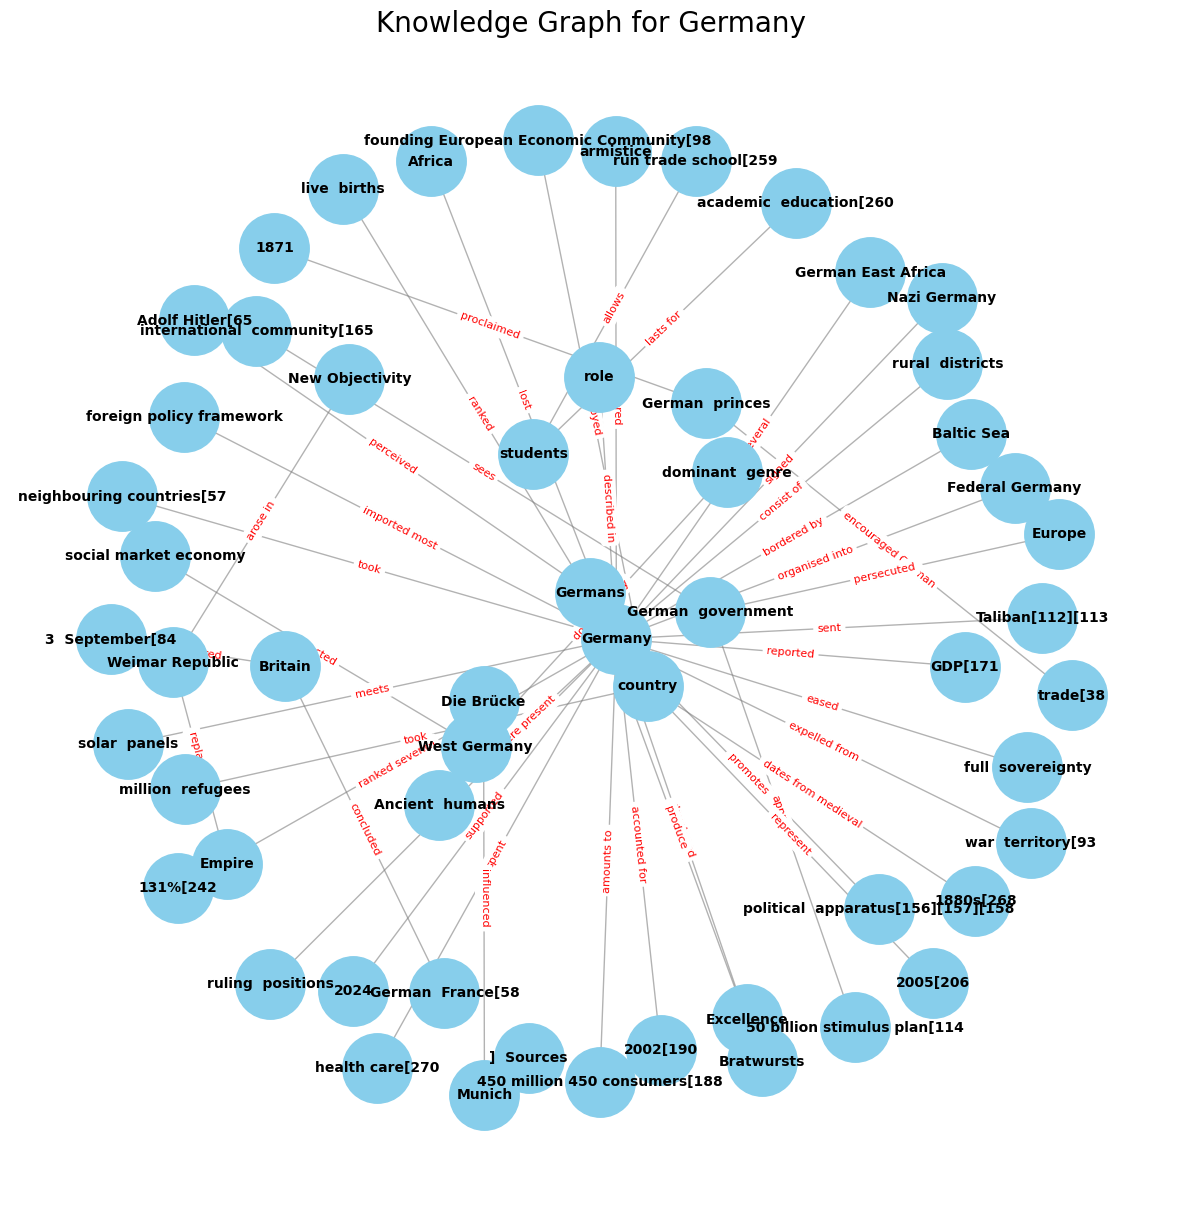

In [28]:
build_and_visualize_kg(kg_df, title=f"Knowledge Graph for {url.split('/')[-1].replace('_', ' ')}", num_nodes_to_show=10) # Adjust num_nodes_to_show

In [ ]:
kg_df.head()  # Display the first few rows of the DataFrame for verification

source                target               edge
0       various  tribes     Neolithic  onward           began in
1      Germanic  tribes  classical  antiquity          inhabited
2                region                    AD  documented before
3               Kingdom     Holy Roman Empire             formed
4  German Confederation                  1815          formed in

In [ ]:
kg_df.shape

(200, 3)